In [4]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

# 데이터 로드

In [5]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

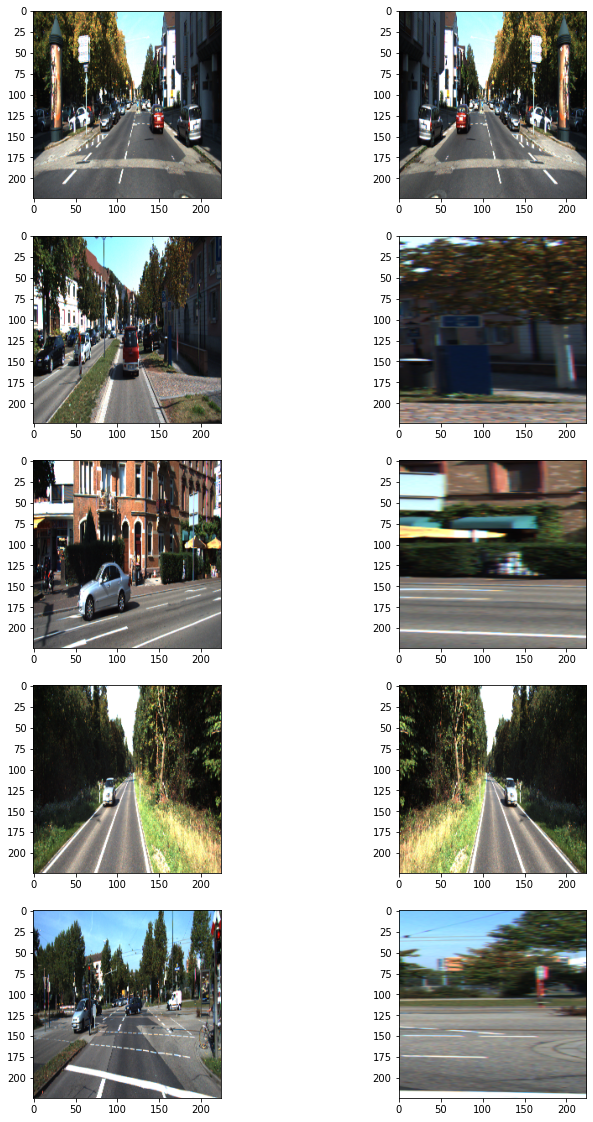

In [6]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [8]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [9]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# U-Net모델 생성

In [10]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [11]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 24s 565ms/step - loss: 0.6930 - val_loss: 0.6926
Epoch 2/100
11/11 [==============================] - 6s 534ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/100
11/11 [==============================] - 6s 537ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 4/100
11/11 [==============================] - 6s 537ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 5/100
11/11 [==============================] - 6s 538ms/step - loss: 0.6908 - val_loss: 0.6905
Epoch 6/100
11/11 [==============================] - 6s 542ms/step - loss: 0.6903 - val_loss: 0.6900
Epoch 7/100
11/11 [==============================] - 6s 542ms/step - loss: 0.6897 - val_loss: 0.6895
Epoch 8/100
11/11 [==============================] - 6s 544ms/step - loss: 0.6892 - val_loss: 0.6889
Epoch 9/100
11/11 [==============================] - 6s 547ms/step - loss: 0.6887 - val_loss: 0.6884
Epoch 10/100
11/11 [==============================] - 6s 548ms/step - loss: 0.6881 - val_l

# 모델 시각화

In [27]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [10]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

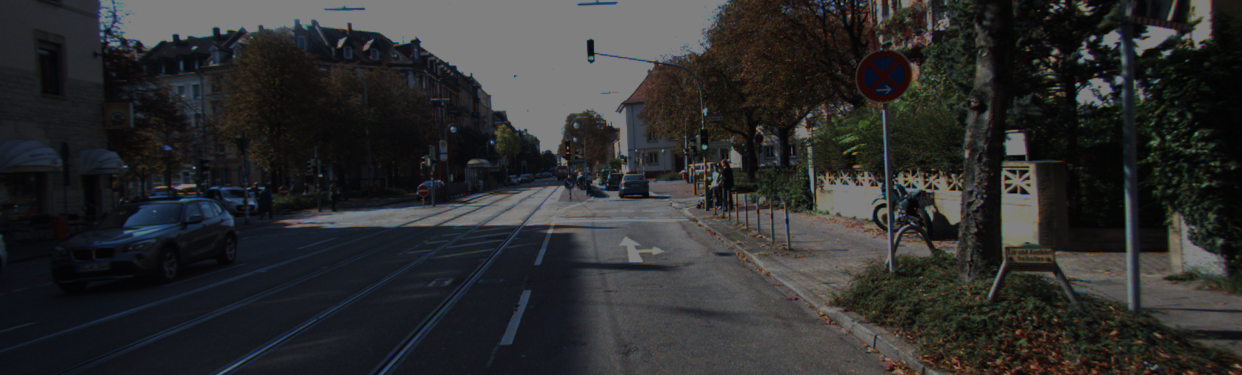

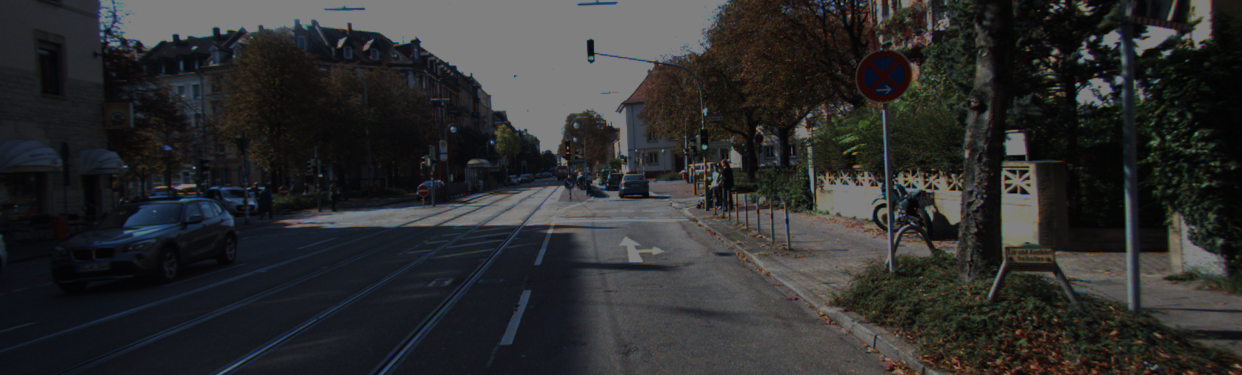

In [11]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [12]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [13]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

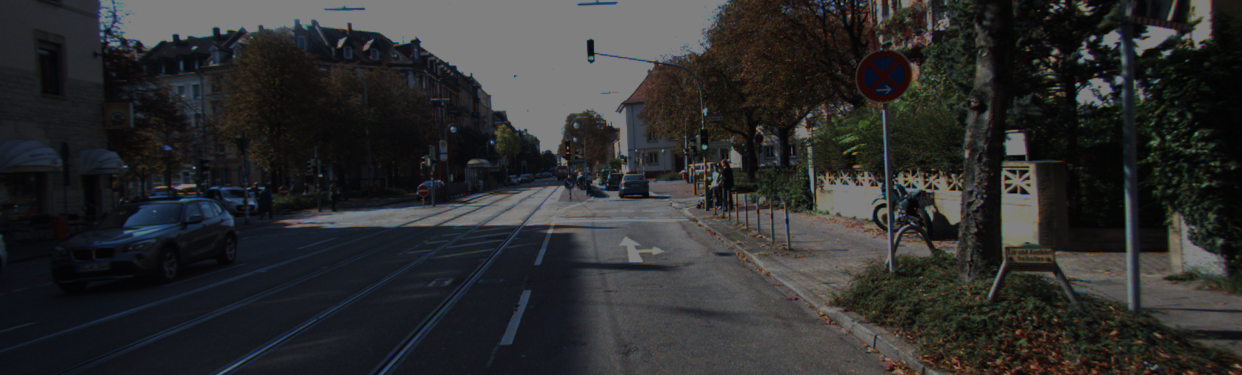

IoU : 0.000000


0.0

In [14]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

# U - Net ++

In [15]:
def build_nested_model(input_shape=(224,224,3), deep_supervision=True, batch_size = 4):
    
    inputs = Input(input_shape)
    
    #Backbone
    conv0_0 = Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    conv0_0 = Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    
    conv1_0 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool0_0)
    conv1_0 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    
    conv2_0 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool1_0)
    conv2_0 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    
    conv3_0 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool2_0)
    conv3_0 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    
    conv4_0 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool3_0)
    conv4_0 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv4_0)
    pool4_0 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    
    #대각 layer    
    # 첫번째   
    # X0,1
    up1_0 = Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv1_0)
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3)
    conv0_1 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1)
    
    # X1,1
    up2_0 = Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv2_0)
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    
    # X2,1
    up3_0 = Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv3_0)
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    
    # X3,1
    up4_0 = Conv2DTranspose(256, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv4_0)
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)  
    
    #두번째
    # X0,2
    up1_1 = Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv1_1)
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis = 3)
    conv0_2 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2)
    
    # X1,2
    up2_1 = Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv2_1)
    merge1_2 = concatenate([up2_1, conv1_0, conv1_0], axis = 3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
    
    # X2,2
    up3_1 = Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv3_1)
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)
    
    #세번째
    # X0,3
    up1_2 = Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv1_2)
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3)
    # X1,3
    up2_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    #네번째
    # X0,4
    up1_3 = Conv2D(32, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_3)) 
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis = 3)
    conv0_4 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_4)

    #deep_supervision
    output1 = Conv2D(1, 1, activation='sigmoid', name = 'output1')(conv0_1)
    output2 = Conv2D(1, 1, activation='sigmoid', name = 'output2')(conv0_2)
    output3 = Conv2D(1, 1, activation='sigmoid', name = 'output3')(conv0_3)
    output4 = Conv2D(1, 1, activation='sigmoid', name = 'output4')(conv0_4)
    
    if deep_supervision:
        model = Model(inputs=inputs, outputs=[output1,
                                               output2,
                                               output3,
                                               output4])
    else:
        model = Model(inputs = inputs, outputs=output4)

    return model

In [16]:
unet_pp_ds = build_nested_model(deep_supervision=True)
unet_pp_ds.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 224, 224, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [17]:
unet_pp = build_nested_model(deep_supervision=False)
unet_pp.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 224, 224, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 224, 224, 32) 9248        conv2d_52[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_53[0][0]                  
____________________________________________________________________________________________

In [18]:
# deep_supervision을 사용하지 않은 모델의 성능을 확인
unet_pp.compile(optimizer = Adam(lr = 3e-4), loss = 'binary_crossentropy')
unet_pp.fit(
     x=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Epoch 1/100


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


11/11 [==============================] - 22s 710ms/step - loss: 0.6872 - val_loss: 0.6477
Epoch 2/100
11/11 [==============================] - 7s 671ms/step - loss: 0.4322 - val_loss: 0.0380
Epoch 3/100
11/11 [==============================] - 7s 651ms/step - loss: 0.0475 - val_loss: 0.0321
Epoch 4/100
11/11 [==============================] - 7s 643ms/step - loss: 0.0378 - val_loss: 0.0301
Epoch 5/100
11/11 [==============================] - 7s 639ms/step - loss: 0.0364 - val_loss: 0.0290
Epoch 6/100
11/11 [==============================] - 7s 639ms/step - loss: 0.0336 - val_loss: 0.0286
Epoch 7/100
11/11 [==============================] - 7s 639ms/step - loss: 0.0334 - val_loss: 0.0308
Epoch 8/100
11/11 [==============================] - 7s 638ms/step - loss: 0.0311 - val_loss: 0.0300
Epoch 9/100
11/11 [==============================] - 7s 637ms/step - loss: 0.0249 - val_loss: 0.0271
Epoch 10/100
11/11 [==============================] - 7s 640ms/step - loss: 0.0274 - val_loss: 0.0309


In [19]:
unet_pp_path = '/seg_model_unet_pp.h5'
unet_pp.save(unet_pp_path)

In [20]:
unet_pp = tf.keras.models.load_model(unet_pp_path)

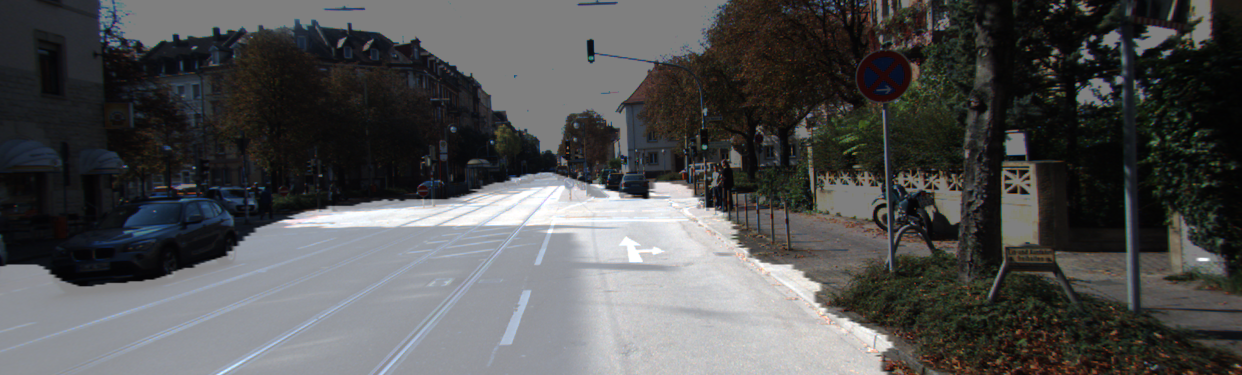

IoU : 0.925844


0.9258443465491923

In [21]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
calculate_iou_score(target, prediction)

In [23]:
def calculate_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    return iou_score

In [24]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

# U - Net과 U - Net++의 Segmentation 결과

In [28]:
unet_iou = []
unet_pp_iou = []

for i in range(25):  # 이미지 25개로 테스트
    # U-Net의 IoU 계산
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_iou.append(calculate_iou(target, prediction))

    # U-Net++의 IoU 계산
    output, prediction, target = get_output(
         unet_pp, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_pp_iou.append(calculate_iou(target, prediction))

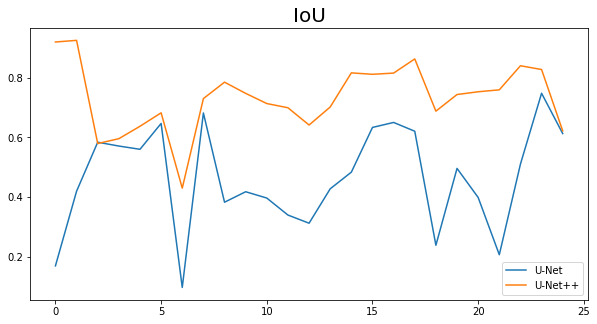

In [29]:
plt.figure(figsize=(10,5))
plt.plot(unet_iou)
plt.plot(unet_pp_iou)
plt.title('IoU', fontsize=20)
plt.legend(['U-Net', 'U-Net++'])
plt.show()

# 회고

U-net++이 U-net보다 파라미터가 3분의 1이나 적지만 성능은 더 좋다.

U-net에 DensNet개념을 적용한게 효과적이었던 것 같다.